In [3]:
from __future__ import print_function
import argparse
import dill
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image

# to load the Fashion MNIST session again:
#filename = 'globalsave.pkl'
#dill.load_session(filename)

class Args:
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.05
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = np.random.randint(32000)
        self.log_interval = 100

args = Args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

In [2]:
label_mapping = {
    0: "T-Shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

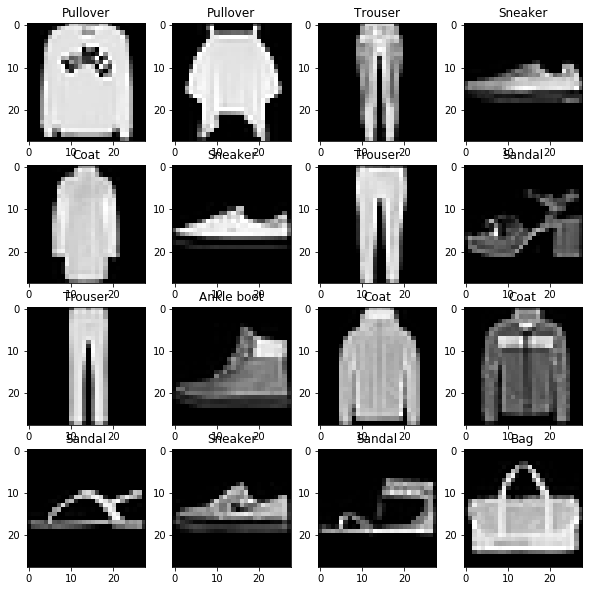

In [12]:
f, axarr = plt.subplots(4,4, figsize=(10,10))
for (i,j) in it.product(range(4), repeat = 2):
    rand_ix = np.random.randint(train_loader.dataset.train_data.shape[0])
    axarr[i,j].imshow(train_loader.dataset.train_data[rand_ix,:,:], cmap='gray')
    axarr[i,j].set_title(label_mapping[train_loader.dataset.train_labels[rand_ix]])
plt.show()

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def visualize_learning_curve():
    pass

def train(loader, epoch):
    model.train()
    loss_hist = np.zeros(loader.__len__())
    accu_hist = np.zeros_like(loss_hist)
    for batch_idx, (data, target) in enumerate(loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        loss_hist[batch_idx] = loss
        pred = output.data.max(1, keepdim=True)[1]
        accu_hist[batch_idx] = pred.eq(target.data.view_as(pred)).cpu().sum() / target.__len__()
        
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.data[0]))

    return loss_hist, accu_hist

def test(loader):
    model.eval()
    test_loss = 0
    correct = 0
    accu = lambda x: x / len(loader.dataset)
    for data, target in loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    return test_loss, accu(correct)

def run(trainInstanceLoader, testInstanceLoader):
    train_loss_evolution = []
    train_acc_evolution = []
    test_loss_evolution = []
    test_acc_evolution = []
    print(args.epochs)
    for epoch in range(1, args.epochs + 1):
        loss_h, acc_h = train(train_loader,epoch)
        loss_t, acc_t = test(test_loader)

        train_loss_evolution = np.concatenate((train_loss_evolution, loss_h), axis=0)
        train_acc_evolution = np.concatenate((train_acc_evolution, acc_h), axis=0)
        test_loss_evolution = np.concatenate((test_loss_evolution, np.expand_dims(np.array(loss_t), axis=0)), axis=0)
        test_acc_evolution = np.concatenate((test_acc_evolution, np.expand_dims(np.array(acc_t), axis=0)), axis=0)
        
    return train_loss_evolution, train_acc_evolution, test_loss_evolution, test_acc_evolution
    
def plot_history(y1, y2, y3, y4):
    f, axarr = plt.subplots(2,2, figsize=(10,10))
    axarr[0,0].plot(y1), axarr[0,0].set_title('Training loss over batches'), axarr[0,0].set_ylim([0, 3])
    axarr[0,1].plot(y2), axarr[0,1].set_title('Training accuracy over batches'), axarr[0,1].set_ylim([0, 1])
    axarr[1,0].plot(y3), axarr[1,0].set_title('Test loss over epoches'), axarr[1,0].set_ylim([0, 1])
    axarr[1,1].plot(y4), axarr[1,1].set_title('Test accuracy over epoches'), axarr[1,1].set_ylim([0, 1])
    plt.show()

# Baseline
Best epoch is last epoch, 87%

10
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290065


/Users/lucasmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.120046
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.921762
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.862842
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.977314
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.596968
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.518208
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.909017
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.578840
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.749774

Test set: Average loss: 0.5305, Accuracy: 7988/10000 (80%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.589371
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.924652
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.672649
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.797333
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.598362
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.516914
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.747345
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.566789
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.554746
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.631

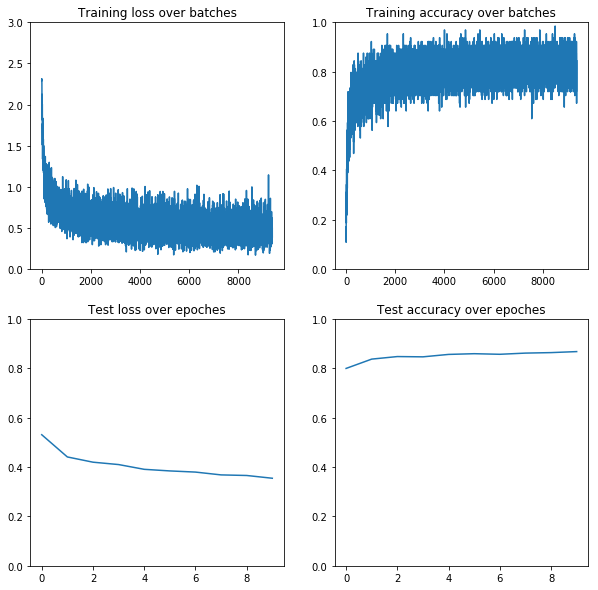

In [11]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

train_loss_evolution, train_acc_evolution, test_loss_evolution, test_acc_evolution = run(train_loader, test_loader)
plot_history(train_loss_evolution, train_acc_evolution, test_loss_evolution, test_acc_evolution)

# Data Augmentation
constant 87%

10
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.484269


/Users/lucasmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.498144
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.387150
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.408770
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.444415
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.371601
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.425435
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.345456
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.591643
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.330234

Test set: Average loss: 0.3575, Accuracy: 8671/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.546957
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.477509
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.383813
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.228839
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.340469
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.501606
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.558175
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.518984
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.439973
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.463

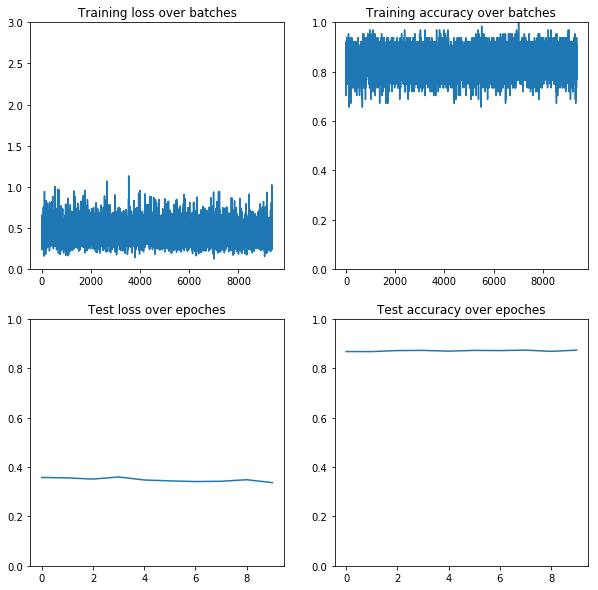

In [49]:
train_loader2 = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.RandomResizedCrop(30),
                       transforms.RandomHorizontalFlip(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader2 = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

train_loss_evolution, train_acc_evolution, test_loss_evolution, test_acc_evolution = run(train_loader, test_loader)
plot_history(train_loss_evolution, train_acc_evolution, test_loss_evolution, test_acc_evolution)

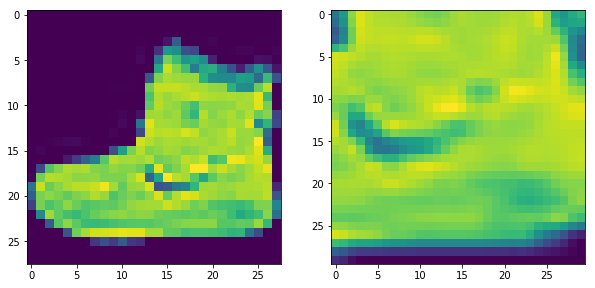

In [44]:
im = Image.fromarray(np.uint8(train_loader.dataset.train_data[0,:,:]))
im = transforms.RandomResizedCrop(30).__call__(im)

f, axarr = plt.subplots(1,2, figsize=(10,10))
axarr[0].imshow(train_loader.dataset.train_data[0,:,:])
axarr[1].imshow(im)

plt.show()

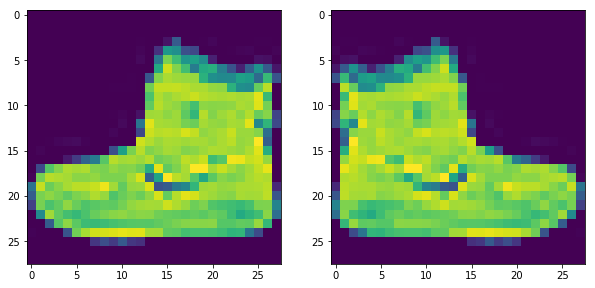

In [48]:
example=transforms.RandomHorizontalFlip()
im = Image.fromarray(np.uint8(train_loader.dataset.train_data[0,:,:]))
im = example.__call__(im)

f, axarr = plt.subplots(1,2, figsize=(10,10))
axarr[0].imshow(train_loader.dataset.train_data[0,:,:])
axarr[1].imshow(im)

plt.show()

# Batch Normalisation

In [57]:
class Netbatch(nn.Module):
    def __init__(self):
        super(Netbatch, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_batch = nn.BatchNorm2d(20)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2_batch(self.conv2(x))), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = Netbatch()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

10
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319471


/Users/lucasmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.252501
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.088184
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.719162
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.623271
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.808211
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.697197
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.705168
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.588271
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.698660

Test set: Average loss: 0.4906, Accuracy: 8031/10000 (80%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.653767
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.634578
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.462350
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.428291
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.549038
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.763793
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.410099
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.450374
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.571115
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.481

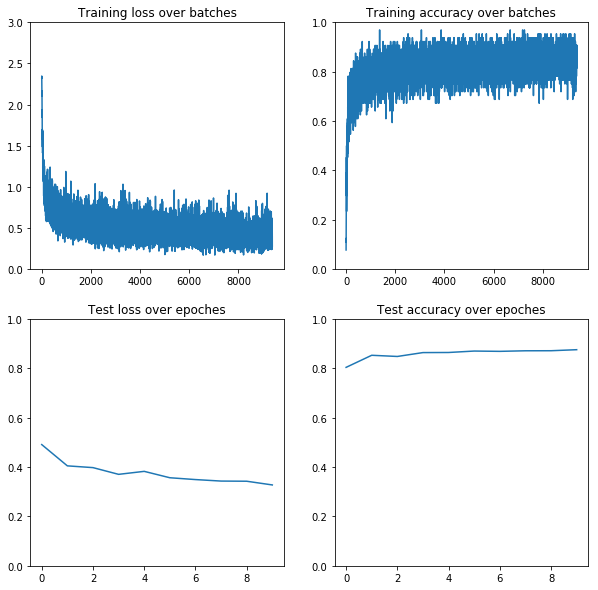

In [58]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

train_loss_evolution, train_acc_evolution, test_loss_evolution, test_acc_evolution = run(train_loader, test_loader)
plot_history(train_loss_evolution, train_acc_evolution, test_loss_evolution, test_acc_evolution)

# Finetuning


10
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320871


/Users/lucasmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.722659
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.864971
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.526395
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.445044
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.328450
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.289124
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.210900
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.165888
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.348798

Test set: Average loss: 0.0930, Accuracy: 9725/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.252979
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.274064
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.128226
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.126168
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.095683
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.220010
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.266189
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.216559
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.207062
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.147

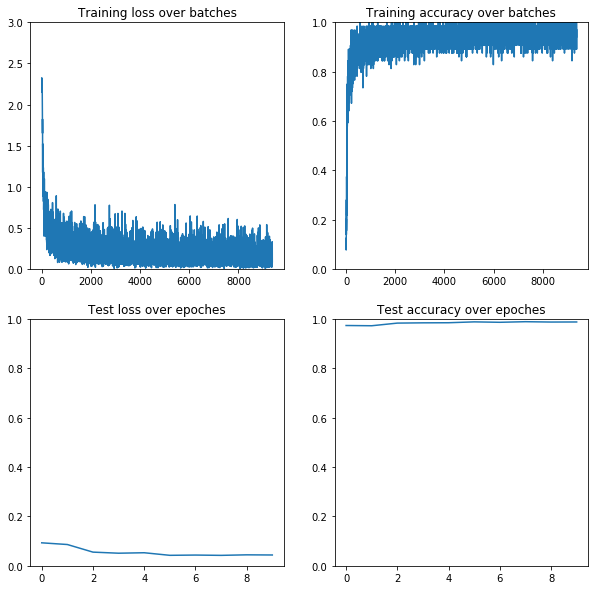

In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../dataMNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../dataMNIST', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

train_loss_evolution, train_acc_evolution, test_loss_evolution, test_acc_evolution = run(train_loader, test_loader)
plot_history(train_loss_evolution, train_acc_evolution, test_loss_evolution, test_acc_evolution)

In [81]:
model = torch.load('finetuning_backup.pt')

10
Train Epoch: 1 [0/60000 (0%)]	Loss: 4.863765


/Users/lucasmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.638491
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.558011
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.853553
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.512327
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.546907
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.566926
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.589615
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.429240
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.540138

Test set: Average loss: 1.2871, Accuracy: 6025/10000 (60%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.530856
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.484023
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.336981
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.467927
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.492254
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.544523
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.479540
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.339151
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.900597
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.449

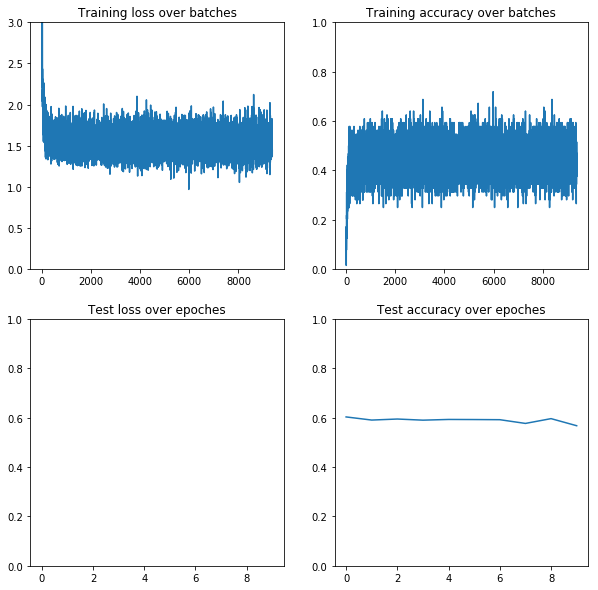

In [79]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

optimizer = optim.SGD(model.fc2.parameters(), lr=args.lr, momentum=args.momentum)
train_loss_evolution, train_acc_evolution, test_loss_evolution, test_acc_evolution = run(train_loader, test_loader)
plot_history(train_loss_evolution, train_acc_evolution, test_loss_evolution, test_acc_evolution)

In [71]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

510
